In [ ]:
# !pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 10.1 MB/s eta 0:00:00


In [1]:
%%capture
import pandas as pd
import tensorflow as tf
import numpy as np
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt

# Classification Model
!pip install transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# Model Training
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# USE GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

In [2]:
# USE GPU

gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


In [3]:
# USE TPU

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

In [4]:
# Get preprocessed data
!rm -rf "/content/Fake-News-Detection-Text-Classification"
!git clone 'https://github.com/shariqfz/Fake-News-Detection-Text-Classification.git'



Cloning into 'Fake-News-Detection-Text-Classification'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 164 (delta 38), reused 9 (delta 9), pack-reused 84
Receiving objects: 100% (164/164), 126.37 MiB | 16.51 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Updating files: 100% (21/21), done.


In [5]:
# read prepocessed data
data_path = '/content/Fake-News-Detection-Text-Classification/data/hate_speech_non_concatenated.csv'
combined_set = pd.read_csv(data_path)

CLASS_NAMES = ["Fake", "Real"]
MAPPING_DICT = {
    "Fake":0,
    "Real":1
}

combined_set = combined_set.dropna()
combined_set.head(10)

,Unnamed: 0,text,Label,hate_speech_class
0,17226,seven miner kill one miss coal mine collaps tu...,1.0,0
1,10782,treasuri weiss wit hous puerto rico hear offic...,1.0,1
2,19623,least peopl kill earthquak mexico least peopl ...,1.0,0
3,16853,graft probe mexico presid alli pose tricki cha...,1.0,0
4,9050,us militari say disclos detail injur servic me...,1.0,2
5,1055,trump consult republican senat fed chief candi...,1.0,2
6,25885,even hi white supremacist base know trump blew...,0.0,2
7,39701,woman born nazi germani say trump doesnt remin...,0.0,2
8,22471,trump slip blame obama russian interfer despit...,0.0,1
9,32521,presid trump receiv patriot jersey close frien...,0.0,2


In [ ]:
# read hate-speech appended data, but remove those hate speech indicators strings
import re

combined_set = pd.read_csv("/content/Fake-News-Detection-Text-Classification/data/hate_speech_concatenated_in_text.csv")

# List of strings to be removed
remove_list = [" Neither Hate Speech nor Offensive$", " Hate Speech$", " Offensive$", ]

# Remove the strings
for item in remove_list:
    combined_set['text'] = combined_set['text'].replace(item, '', regex=True)

print(len(combined_set))
combined_set.text.iloc[9999]

In [6]:
X = combined_set.sample(frac=1)
Y = X.Label.to_numpy().astype('float32').reshape(-1,1)
X = X.text.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    train_size=0.9,
    test_size=0.1,
    stratify=Y,
    random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train,
    train_size=0.9,
    test_size=0.1,
    stratify=y_train,
    random_state=42
)

In [7]:
# Model Callbacks
model_name = "BERTFakeNewsDetector"
MODEL_CALLBACKS = [ModelCheckpoint(model_name, save_best_only=True)]

In [ ]:
import tensorflow_addons as tfa
metric = tfa.metrics.F1Score(num_classes=3, threshold=0.5)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [8]:
# Start of Code taken from https://www.kaggle.com/code/utkarshsaxenadn/fake-vs-real-news-detection-bert-acc-100/notebook#BERT-Classification-Model

bert_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(
    bert_name,
    padding = "max_length",
    do_lower_case = True,
    add_special_tokens = True,
)

X_train_encoded = tokenizer(
    X_train.tolist(),
    padding = True,
    truncation = True,
    return_tensors = "tf"
).input_ids

X_valid_encoded = tokenizer(
    X_valid.tolist(),
    padding = True,
    truncation = True,
    return_tensors = "tf"
).input_ids

X_test_encoded = tokenizer(
    X_test.tolist(),
    padding = True,
    truncation = True,
    return_tensors = "tf"
).input_ids

train_ds = tf.data.Dataset.from_tensor_slices((X_train_encoded, y_train)).shuffle(len(X_train)).batch(8).prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid_encoded, y_valid)).shuffle(len(X_valid)).batch(8).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_encoded, y_test)).shuffle(len(X_test)).batch(8).prefetch(tf.data.AUTOTUNE)

bert_model = TFAutoModelForSequenceClassification.from_pretrained(bert_name, num_labels = 1)

bert_model.compile(
    optimizer = Adam(learning_rate = 1e-5),
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name="Accuracy"),
        tf.keras.metrics.Precision(name="Precision"),
        tf.keras.metrics.Recall(name="Recall"),
        # tf.keras.metrics.F1Score(name='F1_Score'),
        # tfa.metrics.F1Score(num_classes=2, threshold=0.5, name='F1_Score'),
        tf.keras.metrics.AUC(name='AUC')
    ]
)

model_history = bert_model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = 3,
    batch_size = 16,
    callbacks = MODEL_CALLBACKS
)

model_history = pd.DataFrame(model_history.history)

# Save the mdoel
# bert_model.save(model_name)

# End of Code taken from https://www.kaggle.com/code/utkarshsaxenadn/fake-vs-real-news-detection-bert-acc-100/notebook#BERT-Classification-Model

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/3
102/102 [==============================] - 193s 1s/step - loss: 0.2397 - Accuracy: 0.6000 - Precision: 0.6014 - Recall: 0.4436 - AUC: 0.6229 - val_loss: 0.1582 - val_Accuracy: 0.7556 - val_Precision: 0.6667 - val_Recall: 0.9524 - val_AUC: 0.9427
Epoch 2/3
102/102 [==============================] - 142s 1s/step - loss: 0.1091 - Accuracy: 0.8654 - Precision: 0.8523 - Recall: 0.8635 - AUC: 0.9262 - val_loss: 0.0532 - val_Accuracy: 0.9333 - val_Precision: 0.9286 - val_Recall: 0.9286 - val_AUC: 0.9841
Epoch 3/3
102/102 [==============================] - 149s 1s/step - loss: 0.0438 - Accuracy: 0.9531 - Precision: 0.9573 - Recall: 0.9423 - AUC: 0.9848 - val_loss: 0.0525 - val_Accuracy: 0.9333 - val_Precision: 0.9286 - val_Recall: 0.9286 - val_AUC: 0.9737


In [ ]:
# Save the mdoel
# bert_model.save(model_name)

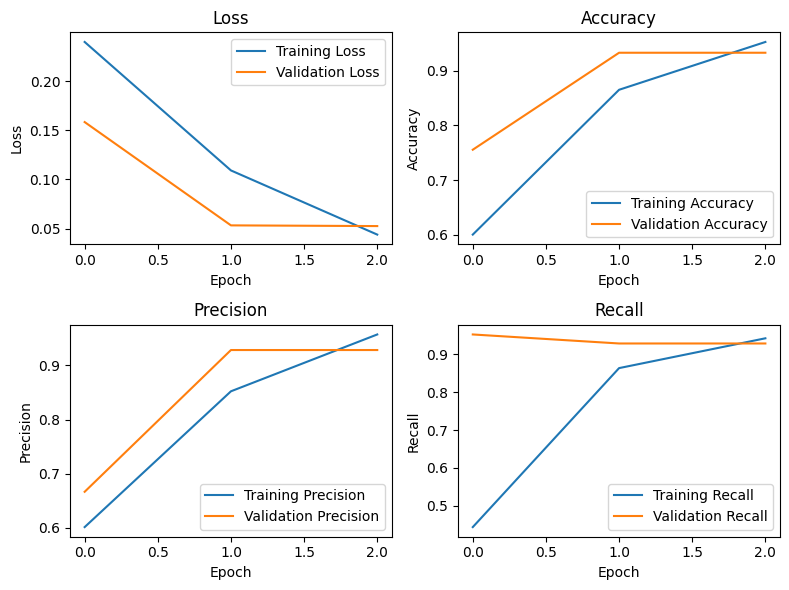

In [11]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Plot data
axs[0, 0].plot(model_history['loss'], label='Training Loss')
axs[0, 0].plot(model_history['val_loss'], label='Validation Loss')

axs[0, 1].plot(model_history['Accuracy'], label='Training Accuracy')
axs[0, 1].plot(model_history['val_Accuracy'], label='Validation Accuracy')

axs[1, 0].plot(model_history['Precision'], label='Training Precision')
axs[1, 0].plot(model_history['val_Precision'], label='Validation Precision')

axs[1, 1].plot(model_history['Recall'], label='Training Recall')
axs[1, 1].plot(model_history['val_Recall'], label='Validation Recall')

# Set subplot titles
axs[0, 0].set_title('Loss')
axs[0, 1].set_title('Accuracy')
axs[1, 0].set_title('Precision')
axs[1, 1].set_title('Recall')

# Set x and y labels
for i in range(2):
    for j in range(2):
        axs[i, j].set_xlabel('Epoch')
        axs[i, j].legend()

axs[0, 0].set_ylabel('Loss')
axs[0, 1].set_ylabel('Accuracy')
axs[1, 0].set_ylabel('Precision')
axs[1, 1].set_ylabel('Recall')

# Adjust layout
plt.tight_layout()
plt.show()


In [12]:
test_loss, test_acc, test_precision, test_recall, test_auc = bert_model.evaluate(test_ds, verbose = 0)

print(f"Test Loss      : {test_loss}")
print(f"Test Accuracy  : {test_acc}")
print(f"Test Precision : {test_precision}")
print(f"Test Recall    : {test_recall}")
# print(f"Test F1        : {tests_f1}")
print(f"Test AUC       : {test_auc}")

Test Loss      : 0.0794825628399849
Test Accuracy  : 0.9100000262260437
Test Precision : 0.8518518805503845
Test Recall    : 0.978723406791687
Test AUC       : 0.9534323215484619


In [20]:
def predict_text(text, model):
    tokens = tokenizer(text, return_tensors = 'tf', padding="max_length", truncation=True).input_ids
    return np.abs(np.round(model.predict(tokens, verbose = 0).logits))

In [13]:
def generateWordCloud(text):
  wordcloud = WordCloud(
      width = 400,
      height = 400,
      background_color = 'black',
      stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

  fig = plt.figure(
    figsize = (3, 3),
    facecolor = 'k',
    edgecolor = 'k')

  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.axis('off')
  plt.tight_layout(pad=0)
  plt.show()

In [16]:
data_true = pd.read_csv("/content/Fake-News-Detection-Text-Classification/data/FakeNewsData/True.csv")
data_fake = pd.read_csv("/content/Fake-News-Detection-Text-Classification/data/FakeNewsData/Fake.csv")

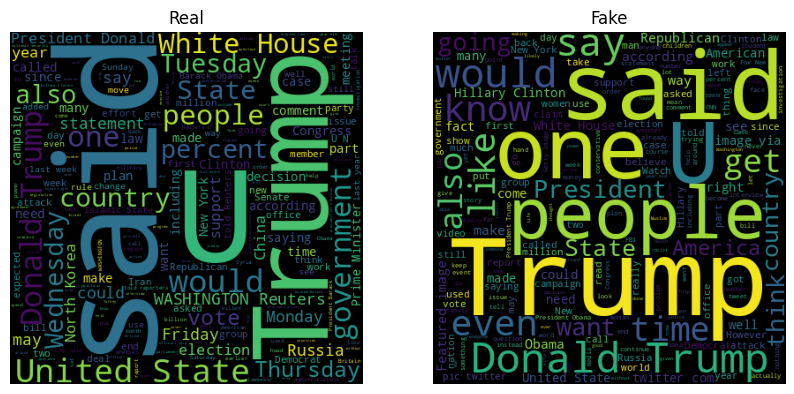

In [17]:
# Generate the wordcloud objects

text_true = ''
for news in data_true.text.values:
    text_true += f" {news}"

text_fake = ''
for news in data_fake.text.values:
    text_fake += f" {news}"

real_wc = WordCloud(width = 400,
      height = 400,
      background_color = 'black',
      stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text_true)

fake_wc = WordCloud(width = 400,
      height = 400,
      background_color = 'black',
      stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text_fake)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the wordclouds on the subplots
ax1.imshow(real_wc)
ax1.set_title("Real")
ax1.axis("off")

ax2.imshow(fake_wc)
ax2.set_title("Fake")
ax2.axis("off")

# Show the figure
plt.show()

In [18]:
def generateWordCloudComparative(text, real_wc=real_wc, fake_wc=fake_wc):

  # Create a figure with two subplots
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

  text_wc = WordCloud(width = 400,
      height = 400,
      background_color = 'black',
      stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

  ax1.imshow(text_wc)
  ax1.set_title(text[:20] + "...")
  ax1.axis("off")

  ax2.imshow(real_wc)
  ax2.set_title("Real")
  ax2.axis("off")

  ax3.imshow(fake_wc)
  ax3.set_title("Fake")
  ax3.axis("off")

  # Show the figure
  plt.show()

In [18]:
y_test_list = [x[0] for x in y_test.astype('int32').tolist()]

In [19]:
X_test_list = X_test.tolist()
X_test_list[0]

'russia say highlevel contact north korea possibl ifax russian deputi foreign minist igor morgulov said moscow highlevel contact new north korean leadership possibl interfax news agenc report friday theori contact possibl interfax quot morgulov say morgulov said russia mani commun channel north korea one way anoth bear fruit'

In [20]:
test_df_to_save = pd.DataFrame({'text':X_test_list, 'Label': y_test_list})
test_df_to_save.head()
test_df_to_save.to_csv("test_data_for_bert.csv")

In [21]:
# Print Misclassifications
misclassifications = []
count = 0
for index in range(len(X_test)):

    text = X_test[index]
    true = y_test[index]
    model_pred = predict_text(text, model = bert_model)[0]

    if (true != model_pred):
      count += 1
      # if CLASS_NAMES[int(model_pred)] == "Real" and count_pred_real < 100:
        # count_pred_real += 1
      misclassifications.append({'text': text, 'true': CLASS_NAMES[int(true)], 'prediction': CLASS_NAMES[int(model_pred)]})
      print(f"ORGINAL TEXT:\n\n{X_test[index][:100]}\n\nTRUE: {CLASS_NAMES[int(true)]}\tPREDICTED: {CLASS_NAMES[int(model_pred)]}\n")
      print(f"{'-'*100}\n")

print()
print(count)

      # print(f"ORGINAL TEXT:\n\n{X_test[index][:100]}\n\nTRUE: {CLASS_NAMES[int(true)]}\tPREDICTED: {CLASS_NAMES[int(model_pred)]}\n")

      # generateWordCloud(X_test[index])
      # generateWordCloudComparative(X_test[index])
      # print(f"{'-'*100}\n")
      # count += 1


ORGINAL TEXT:

senat democrat plan forc guncontrol amend gop bill repeal obamacar word yet plan defund state depart

TRUE: Fake	PREDICTED: Real

----------------------------------------------------------------------------------------------------

ORGINAL TEXT:

instantview hous republican pass revis obamacar overhaul us hous repres approv bill thursday repeal 

TRUE: Real	PREDICTED: Fake

----------------------------------------------------------------------------------------------------

ORGINAL TEXT:

us mosqu link terrorist group receiv million feder fund interest note terrorist organ link thi mosqu

TRUE: Fake	PREDICTED: Real

----------------------------------------------------------------------------------------------------

ORGINAL TEXT:

trump effect onli day meet presid trump pope franci deliv surpris messag italian worker flashback fe

TRUE: Fake	PREDICTED: Real

----------------------------------------------------------------------------------------------------

ORGINAL TEXT

In [52]:
# Print Misclassifications

miss_length = []
correct_length = []

for index in range(len(X_test)):

    text = X_test[index]
    true = y_test[index]
    model_pred = predict_text(text, model = bert_model)[0]

    if (true != model_pred):
      miss_length.append(len(text.split(' ')))
    else:
      correct_length.append(len(text.split(' ')))

      # misclassifications.append({'text': text, 'true': true, 'prediction': CLASS_NAMES[int(model_pred)]})

      # print(f"ORGINAL TEXT:\n\n{text[:100]}\n\nTRUE: {true}\tPREDICTED: {CLASS_NAMES[int(model_pred)]}\n")

      # generateWordCloud(X_test[index])
      # generateWordCloudComparative(text)
      # print(f"{'-'*100}\n")

print(f'avg length of misclassifications      = {sum(miss_length) / len(miss_length)}')
print(f'avg length of correct classifications = {sum(correct_length) / len(correct_length)}')

avg length of misclassifications      = 243.66666666666666
avg length of correct classifications = 244.08247422680412


In [ ]:
# Print Misclassifications
misclassifications = []
count_pred_real = 0
count_pred_fake = 0
for index in range(len(X_test)):


    text = X_test[index]
    true = y_test[index]
    model_pred = predict_text(text, model = bert_model)[0]

    if (true != model_pred):
      if CLASS_NAMES[int(model_pred)] == "Real" and count_pred_real < 100:
        count_pred_real += 1
        misclassifications.append({'text': text, 'true': CLASS_NAMES[int(true)], 'prediction': CLASS_NAMES[int(model_pred)]})
        print(f"ORGINAL TEXT:\n\n{X_test[index][:100]}\n\nTRUE: {CLASS_NAMES[int(true)]}\tPREDICTED: {CLASS_NAMES[int(model_pred)]}\n")
        print(f"{'-'*100}\n")


      elif CLASS_NAMES[int(model_pred)] == "Fake" and count_pred_fake < 6:
        count_pred_fake += 1
        misclassifications.append({'text': text, 'true': CLASS_NAMES[int(true)], 'prediction': CLASS_NAMES[int(model_pred)]})
        print(f"ORGINAL TEXT:\n\n{X_test[index][:100]}\n\nTRUE: {CLASS_NAMES[int(true)]}\tPREDICTED: {CLASS_NAMES[int(model_pred)]}\n")
        print(f"{'-'*100}\n")

      else:
        break

      # print(f"ORGINAL TEXT:\n\n{X_test[index][:100]}\n\nTRUE: {CLASS_NAMES[int(true)]}\tPREDICTED: {CLASS_NAMES[int(model_pred)]}\n")

      # generateWordCloud(X_test[index])
      # generateWordCloudComparative(X_test[index])
      # print(f"{'-'*100}\n")
      # count += 1


In [22]:
misclassifications_df = pd.DataFrame(misclassifications)
misclassifications_df.to_csv("misclassifications_bert.csv")
misclassifications_df

,text,true,prediction
0,texa politician slam tweet sent florida shoot ...,Real,Fake
1,christi slam social media new jersey press urg...,Real,Fake


ORGINAL TEXT:

russia say highlevel contact north korea possibl ifax russian deputi foreign minist igor morgulov sa

TRUE: Real	PREDICTED: Real



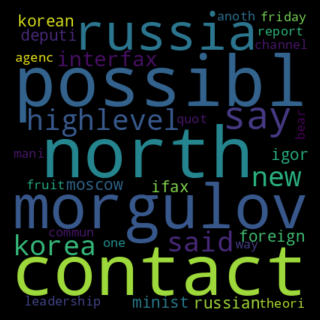

----------------------------------------------------------------------------------------------------

ORGINAL TEXT:

us say one china polici use bargain chip white hous monday insist washington one china polici use ba

TRUE: Real	PREDICTED: Real



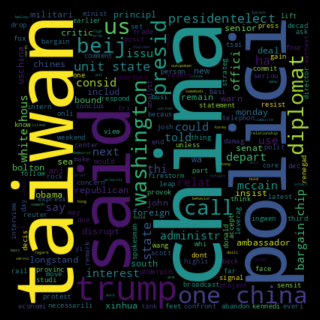

----------------------------------------------------------------------------------------------------

ORGINAL TEXT:

franc defend iran nuclear deal trump call deepli flaw franc made new plea monday unit state preserv 

TRUE: Real	PREDICTED: Real



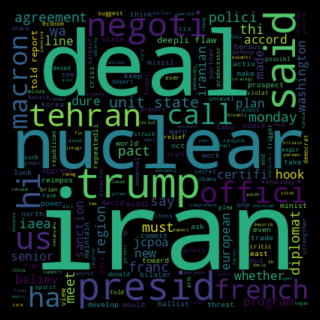

----------------------------------------------------------------------------------------------------

ORGINAL TEXT:

break fbi suspect jare kushner russian stoog detail wa recent report someon within highest rank trum

TRUE: Fake	PREDICTED: Fake



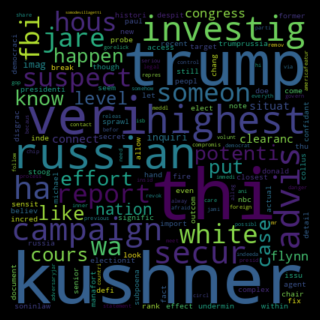

----------------------------------------------------------------------------------------------------



In [23]:
# Print correct classifications

count = 0
for index in range(len(X_test)):
    if count == 4: break

    text = X_test[index]
    true = y_test[index]
    model_pred = predict_text(text, model = bert_model)[0]

    if (true == model_pred):
      print(f"ORGINAL TEXT:\n\n{X_test[index][:100]}\n\nTRUE: {CLASS_NAMES[int(true)]}\tPREDICTED: {CLASS_NAMES[int(model_pred)]}\n")

      generateWordCloud(X_test[index])
      print(f"{'-'*100}\n")
      count += 1


## Model for hate-speech merged fake news data

In [ ]:
# Get preprocessed data
!rm -rf "/content/Fake-News-Detection-Text-Classification"
!git clone 'https://github.com/shariqfz/Fake-News-Detection-Text-Classification.git'

CLASS_NAMES = ["Fake", "Real"]
MAPPING_DICT = {
    "Fake":0,
    "Real":1
}

Cloning into 'Fake-News-Detection-Text-Classification'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 64 (delta 19), reused 19 (delta 3), pack-reused 9
Receiving objects: 100% (64/64), 142.42 MiB | 7.83 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Updating files: 100% (15/15), done.


In [ ]:

"""
class meanings:

0 - hate speech
1 - offensive language
2 - neither

"""

In [22]:
data = pd.read_csv("/content/Fake-News-Detection-Text-Classification/data/hate_speech_concatenated_in_text.csv")
data.text.iloc[4]

'us militari say disclos detail injur servic member us militari provid detail specif case american servic member injur iraq syria becaus could give inform islam state milit pentagon spokesman said tuesday spokesman peter cook wa respond question pentagon press brief seek confirm four american wound syria earlier thi month cook said chang polici aggreg number would still provid polici identifi wound servic member varieti reason includ oper secur includ privaci reason cook said also want provid addit inform enemi might enhanc assess battlefield situat said howev pentagon ha releas inform past respond queri wa unclear cook comment consist previou disclosur last month spokesman said two us servic member injur one iraq syria dure last weekend may captain jeff davi said incid iraq took place north near erbil injuri syria wa north raqqa islam state de facto capit accord pentagon data american servic member wound action sinc start oper inher resolv militari name oper target islam state milit i

### Create data and model training pipeline

In [23]:
data = pd.read_csv("/content/Fake-News-Detection-Text-Classification/data/hate_speech_concatenated_in_text.csv")
data = data.sample(1000)    # shuffle the data

X = data.sample(1000)
Y = X.Label.to_numpy().astype('float32').reshape(-1,1)
X = X.text.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    train_size=0.9,
    test_size=0.1,
    stratify=Y,
    random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train,
    train_size=0.9,
    test_size=0.1,
    stratify=y_train,
    random_state=42
)

In [24]:
data.text.iloc[0]

'trump brag size hi hand hurrican irma relief event video size donald trump hand seem issu even socal presid marco rubio mock size trump tini hand dure campaign last year taller like whi understand whi hi hand size someon rubio said time seen hi hand know say men small hand republican debat trump held hi hand said audienc look hand small hand second time two week trump brought size hi hand help hurrican relief thursday trump wa napl florida photoop trump wa get readi pass sandwich fudg put hi glove accord white hous pool report small trump saidher moment presid trump need bigger foodservic glove peter stevenson peterwstevenson septemb two week ago trump made similar remark hi yuge hand hand big said turn toward cameraa put plastic glove serv food nrg stadium presid trump turn press say hand big pat ward warddpatrick septemb interview washington post trump spoke hi strong hand hand normal hand said wa line shake hand support one support said mr trump strong hand good size hand anoth one

In [25]:

# Model Callbacks
model_name_2 = "BERTFakeNewsDetectorWithHateSpeech"
MODEL_CALLBACKS = [ModelCheckpoint(model_name_2, save_best_only=True)]

# Approach 1

bert_name_2 = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(
    bert_name_2,
    padding = "max_length",
    do_lower_case = True,
    add_special_tokens = True,
)

X_train_encoded = tokenizer(
    X_train.tolist(),
    padding = True,
    truncation = True,
    return_tensors = "tf"
).input_ids

X_valid_encoded = tokenizer(
    X_valid.tolist(),
    padding = True,
    truncation = True,
    return_tensors = "tf"
).input_ids

X_test_encoded = tokenizer(
    X_test.tolist(),
    padding = True,
    truncation = True,
    return_tensors = "tf"
).input_ids

train_ds = tf.data.Dataset.from_tensor_slices((X_train_encoded, y_train)).shuffle(len(X_train)).batch(8).prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid_encoded, y_valid)).shuffle(len(X_valid)).batch(8).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_encoded, y_test)).shuffle(len(X_test)).batch(8).prefetch(tf.data.AUTOTUNE)

bert_model_2 = TFAutoModelForSequenceClassification.from_pretrained(bert_name_2, num_labels = 1)

bert_model_2.compile(
    optimizer = Adam(learning_rate = 1e-5),
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name="Accuracy"),
        tf.keras.metrics.Precision(name="Precision"),
        tf.keras.metrics.Recall(name="Recall"),
        # tf.keras.metrics.F1Score(name='F1_Score'),
        # tfa.metrics.F1Score(num_classes=2, threshold=0.5, name='F1_Score'),
        tf.keras.metrics.AUC(name='AUC')
    ]
)

model_history_2 = bert_model_2.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = 3,
    batch_size = 16,
    callbacks = MODEL_CALLBACKS
)

model_history_2 = pd.DataFrame(model_history_2.history)

# Save the mdoel
# bert_model.save(model_name)


Epoch 1/3
102/102 [==============================] - 186s 1s/step - loss: 0.2216 - Accuracy: 0.6247 - Precision: 0.6110 - Recall: 0.5564 - AUC: 0.6894 - val_loss: 0.1680 - val_Accuracy: 0.7778 - val_Precision: 0.6774 - val_Recall: 1.0000 - val_AUC: 0.9425
Epoch 2/3
102/102 [==============================] - 149s 1s/step - loss: 0.0892 - Accuracy: 0.8901 - Precision: 0.8946 - Recall: 0.8688 - AUC: 0.9488 - val_loss: 0.0842 - val_Accuracy: 0.8889 - val_Precision: 0.8333 - val_Recall: 0.9524 - val_AUC: 0.9293
Epoch 3/3
102/102 [==============================] - 162s 2s/step - loss: 0.0494 - Accuracy: 0.9519 - Precision: 0.9647 - Recall: 0.9318 - AUC: 0.9751 - val_loss: 0.0684 - val_Accuracy: 0.9000 - val_Precision: 0.8511 - val_Recall: 0.9524 - val_AUC: 0.9779


### Plot metrics

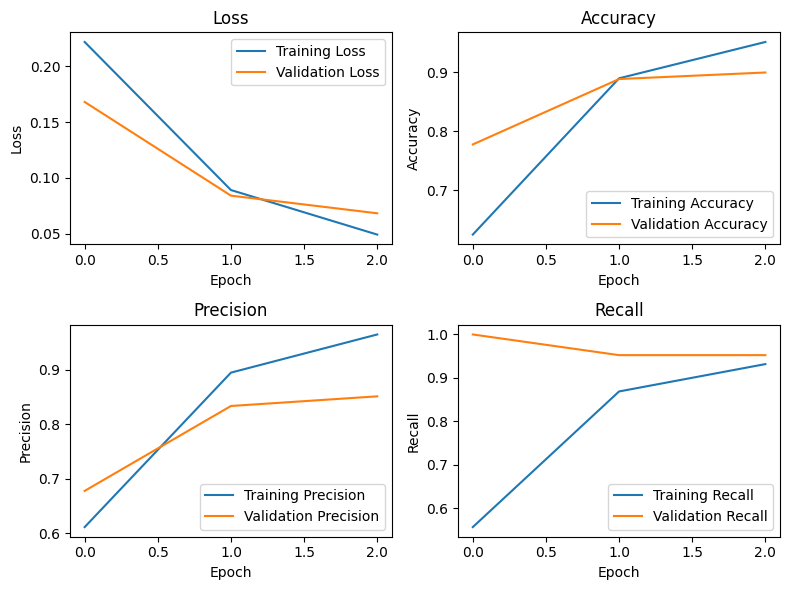

In [26]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Plot data
axs[0, 0].plot(model_history_2['loss'], label='Training Loss')
axs[0, 0].plot(model_history_2['val_loss'], label='Validation Loss')

axs[0, 1].plot(model_history_2['Accuracy'], label='Training Accuracy')
axs[0, 1].plot(model_history_2['val_Accuracy'], label='Validation Accuracy')

axs[1, 0].plot(model_history_2['Precision'], label='Training Precision')
axs[1, 0].plot(model_history_2['val_Precision'], label='Validation Precision')

axs[1, 1].plot(model_history_2['Recall'], label='Training Recall')
axs[1, 1].plot(model_history_2['val_Recall'], label='Validation Recall')

# Set subplot titles
axs[0, 0].set_title('Loss')
axs[0, 1].set_title('Accuracy')
axs[1, 0].set_title('Precision')
axs[1, 1].set_title('Recall')

# Set x and y labels
for i in range(2):
    for j in range(2):
        axs[i, j].set_xlabel('Epoch')
        axs[i, j].legend()

axs[0, 0].set_ylabel('Loss')
axs[0, 1].set_ylabel('Accuracy')
axs[1, 0].set_ylabel('Precision')
axs[1, 1].set_ylabel('Recall')

# Adjust layout
plt.tight_layout()
plt.show()


In [27]:
test_loss, test_acc, test_precision, test_recall, test_auc = bert_model_2.evaluate(test_ds, verbose = 0)

print(f"Test Loss      : {test_loss}")
print(f"Test Accuracy  : {test_acc}")
print(f"Test Precision : {test_precision}")
print(f"Test Recall    : {test_recall}")
# print(f"Test F1        : {tests_f1}")
print(f"Test AUC       : {test_auc}")

Test Loss      : 0.048980046063661575
Test Accuracy  : 0.9300000071525574
Test Precision : 0.8846153616905212
Test Recall    : 0.978723406791687
Test AUC       : 0.9915696382522583


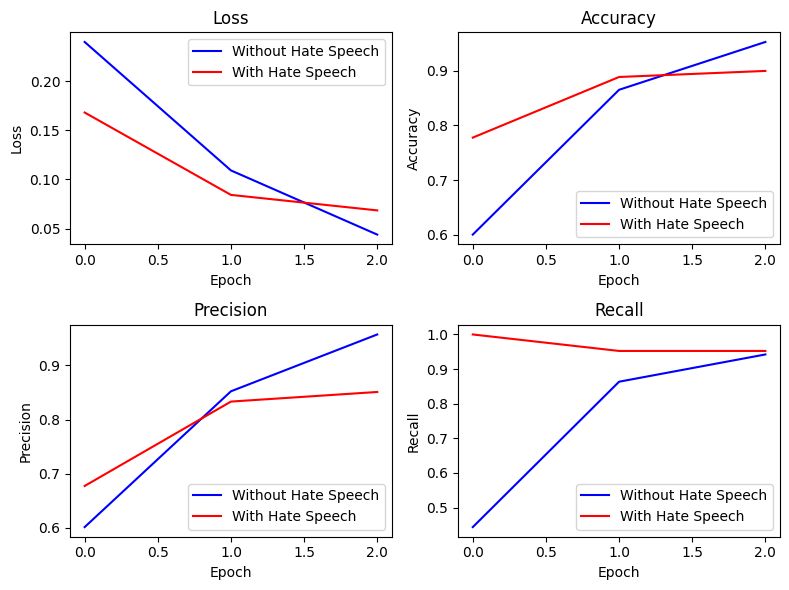

In [29]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Plot data
axs[0, 0].plot(model_history['loss'], label='Without Hate Speech', color='blue')
axs[0, 0].plot(model_history_2['val_loss'], label='With Hate Speech', color='red')

axs[0, 1].plot(model_history['Accuracy'], label='Without Hate Speech', color='blue')
axs[0, 1].plot(model_history_2['val_Accuracy'], label='With Hate Speech', color='red')

axs[1, 0].plot(model_history['Precision'], label='Without Hate Speech', color='blue')
axs[1, 0].plot(model_history_2['val_Precision'], label='With Hate Speech', color='red')

axs[1, 1].plot(model_history['Recall'], label='Without Hate Speech', color='blue')
axs[1, 1].plot(model_history_2['val_Recall'], label='With Hate Speech', color='red')

# Set subplot titles
axs[0, 0].set_title('Loss')
axs[0, 1].set_title('Accuracy')
axs[1, 0].set_title('Precision')
axs[1, 1].set_title('Recall')

# Set x and y labels
for i in range(2):
    for j in range(2):
        axs[i, j].set_xlabel('Epoch')
        axs[i, j].legend()

axs[0, 0].set_ylabel('Loss')
axs[0, 1].set_ylabel('Accuracy')
axs[1, 0].set_ylabel('Precision')
axs[1, 1].set_ylabel('Recall')

# Adjust layout
plt.tight_layout()
plt.show()


In [32]:
misclassifications = pd.read_csv("/content/Fake-News-Detection-Text-Classification/BERT/misclassifications_bert_hate_speech_appended.csv")
misclassifications_copy = misclassifications.copy()
len(misclassifications_copy)

2

In [33]:
misclassifications_copy.text.iloc[0]

'texa politician slam tweet sent florida shoot offic texa lieuten governor dan patrick republican evangel christian sunday delet tweet mani saw offens insensit wa sent shortli deadli attack gay nightclub florida deceiv god cannot mock man reap sow read bibl vers patrick sent hi offici twitter account hour worst mass shoot us histori left least dead hi offic wa immedi avail comment ha told local media includ dalla morn new tweet schedul releas well befor shoot offic regularli send bibl vers sunday ha sinc delet replac anoth passag said delet tweet politician ha condemn samesex marriag fought lgbt right still rais ire accus patrick blame victim disgrac state thi time nation sorrow resign promin lgbt activist georg takei wrote twitter texa democrat parti call patrick apolog immedi make thi right better thi said statement patrick current countri ha yet made comment media tweet new vers sent hi account read salvat righteou come lord stronghold time troubl Hate Speech'

### Check performance on previous classifier's misclassifications

In [34]:
misclassifications_copy

,Unnamed: 0.1,Unnamed: 0,text,true,prediction
0,0,0,texa politician slam tweet sent florida shoot ...,Real,Fake
1,1,1,christi slam social media new jersey press urg...,Real,Fake


In [39]:
# Print Misclassifications

miss_length = []
correct_length = []

for index in range(len(X_test)):

    text = X_test[index]
    true = y_test[index]
    model_pred = predict_text(text, model = bert_model)[0]

    if (true != model_pred):
      miss_length.append(len(text.split(' ')))
    else:
      correct_length.append(len(text.split(' ')))

      # misclassifications.append({'text': text, 'true': true, 'prediction': CLASS_NAMES[int(model_pred)]})

      # print(f"ORGINAL TEXT:\n\n{text[:100]}\n\nTRUE: {true}\tPREDICTED: {CLASS_NAMES[int(model_pred)]}\n")

      # generateWordCloud(X_test[index])
      # generateWordCloudComparative(text)
      # print(f"{'-'*100}\n")

print(f'avg length of misclassifications      = {sum(miss_length) / len(miss_length)}')
print(f'avg length of correct classifications = {sum(correct_length) / len(correct_length)}')

avg length of misclassifications      = 235.0
avg length of correct classifications = 262.1546391752577
